### Case Study 3 : Spam classifier

Submitted by:

- Ravi Sivaraman
- Balaji Avvaru
- Apurv Mittal

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from os.path import isfile
import email
#import nlp
#import spacy
#import BeautifulSoup
from bs4 import BeautifulSoup
import re
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import silhouette_score
import hdbscan
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn import metrics as mt
from sklearn import feature_extraction
#from sklearn.feature_selection import text


import warnings
warnings.filterwarnings("ignore")

In [6]:
# location of emails
#data_path = "/Users/balaj/OneDrive/Desktop/Docs/Docs 1/SMU/MSDS 7333/Case Study 3/Data"
data_path = "/Users/ravis/Library/CloudStorage/OneDrive-SouthernMethodistUniversity/Case Study 3/SpamAssassinMessages"
# get all sub folders
sub_folders = [x[0] for x in os.walk(data_path) if x[0] != data_path]

In [7]:
%%time
# read all emails from all sub folders
mail_ty = []
text_ty = []
data = []
target = []

for folder in sub_folders:
    files = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
    for file in files:
        with open(f"{folder}/{file}", encoding="latin1") as f:
            #    with open(f"{folder}/{file}","r") as f:
            x = email.message_from_file(f)
          #  print(x)
    #    if (file != 'cmds'): 
    #        mail_data.append(lines)
            
        mail_type = x.get_content_type()
        text_type = x.get_content_charset()
        mail_ty.append(mail_type)
        text_ty.append(text_type)
        if re.search("spam", folder):
            target.append(1)
        else:
             target.append(0)
                               
        if mail_type == "text/html":
            tmp = BeautifulSoup(x.get_payload(), 'html.parser')
            tmp = tmp.text.replace("\n", " ")
            data.append(tmp)
        elif "multipart" in mail_type:
            
            multipart_data = []
            for text in x.get_payload():
                if not isinstance(text, str): 
                    if text.get_content_type() == "text/html":
                        tmp = BeautifulSoup(text.get_payload(), 'html.parser')
                        tmp = tmp.text.replace("\n", " ")
                        multipart_data.append(tmp)
                    else:
                        multipart_data.append(text.get_payload()) 
                
            multipart_email = [''.join(str(item)) for item in multipart_data]
            data.append(multipart_email)
        else:
            data.append(x.get_payload()) 
                       

CPU times: user 10.7 s, sys: 3.35 s, total: 14.1 s
Wall time: 17min 26s


In [8]:
df = pd.DataFrame()

In [9]:
df["mail_types"] = mail_ty
df["text_types"] = text_ty

In [10]:
# Count of mail types
df["mail_types"].value_counts()

text/plain                     7413
text/html                      1193
multipart/alternative           326
multipart/signed                180
multipart/mixed                 179
multipart/related                56
multipart/report                  5
text/plain charset=us-ascii       1
Name: mail_types, dtype: int64

In [11]:
# Count of text types
df["text_types"].value_counts()

us-ascii           3275
iso-8859-1         1958
windows-1252        197
iso-8859-15         104
utf-8                22
default              15
iso-8859-2           13
gb2312               11
windows-1251         11
default_charset      10
iso-2022-jp           8
ks_c_5601-1987        7
windows-1254          6
koi8-r                6
iso-8859-9            4
unknown-8bit          2
iso-8859-3            1
gb2312_charset        1
windows-1256          1
chinesebig5           1
euc-kr                1
Name: text_types, dtype: int64

In [12]:
# Create a data frame with email text and target (whether mail is spam or not, 1 for spam and 0 for not a spam)
email_df = pd.DataFrame()
email_df["data"] = data
#email_df["mail_type"] = mail_ty
#email_df["text_type"] = text_ty
email_df["target"] = target

In [13]:
email_df['target'].value_counts()

0    6954
1    2399
Name: target, dtype: int64

In [14]:
email_df

,data,target
0,"Dear Homeowner,\n \nInterest Rates are at thei...",1
1,"[Friend,Now you can copy DVD's and Games\nhttp...",1
2,[ Pocket the newest 8 year annuity!\t Pocket t...,1
3,Congratulations! You Get a Free Handheld Orga...,1
4,ATTENTION: This is a MUST for ALL Computer Use...,1
...,...,...
9348,"I'm one of the 30,000 but it's not working ver...",0
9349,Damien Morton quoted:\n>W3C approves HTML 4 'e...,0
9350,"On Mon, 2002-07-22 at 06:50, che wrote:\n\n> t...",0
9351,"Once upon a time, Manfred wrote :\n\n> I would...",0


In [15]:
email_df.loc[1].data

["Friend,Now you can copy DVD's and Games\nhttp://www.terra.es/personal9/iop1008/\n\nBACKUP DVD VIDEO's WITH YOUR CD-R BURNER\n\nWith 321 studio's software, you can now copy\nany DVD and Playstation Game.  Never buy another \nbackup DVD movie again.  Just copy it!\n\nThis is the first time this software is being made\navailable to the public. All the software you need \nto burn your own DVD Video, is included in 321 Studio's \nsoftware package DVD Copy Plus!  The movies will play \nin a standard DVD player. With detailed, easy to follow, \nstep-by-step instructions, you can BURN your own DVD \nVideo using nothing more than your DVD-ROM \nand CD-R drives. Purchase a copy! Click below.\n\nhttp://www.terra.es/personal9/iop1008/\n\nOrder today and receive!\n\n*Step by Step Interactive Instructions\n*All Software Tools Included On CD\n*No DVD Burner Required\n*FREE Live Technical Support\n*30 Day Risk Free Trial Available\n\nWith DVD Copy Plus you can backup Your DVD Movies with \nthe same 

In [16]:
email_df["data_new"] = [''.join(str(item)) for item in email_df.data]

In [17]:
print(email_df["data_new"][0])

Dear Homeowner,
 
Interest Rates are at their lowest point in 40 years!

We help you find the best rate for your situation by
matching your needs with hundreds of lenders!

Home Improvement, Refinance, Second Mortgage,
Home Equity Loans, and More! Even with less than
perfect credit!

This service is 100% FREE to home owners and new
home buyers without any obligation. 

Just fill out a quick, simple form and jump-start
your future plans today!


Visit http://61.145.116.186/user0201/index.asp?Afft=QM10






To unsubscribe, please visit:

http://61.145.116.186/light/watch.asp





In [24]:
# get the instanc of TfidfVectorizer
my_stop_words = feature_extraction.text.ENGLISH_STOP_WORDS.union(["spamassassin", 
                                               "email", "message", "\n", "nbsp", "font","exhm", "subject",
                                               "list", "url", "net"])
tf_vectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words=my_stop_words)

In [19]:
text

In [25]:
# fit and transform email data
new_vectors = tf_vectorizer.fit_transform(email_df.data_new)

In [26]:
new_vectors.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.02419715, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

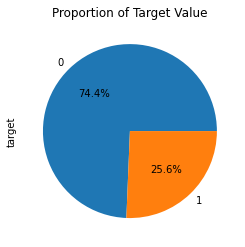

In [27]:
# Pie chart
email_df.target.value_counts().plot.pie(autopct = "%.1f%%")
plt.title("Proportion of Target Value")
plt.show()

In [33]:
k_val = 16
kmeans = KMeans(n_clusters=k_val, init='k-means++', max_iter=200, n_init=10)
kmeans.fit(X)
labels=kmeans.labels_
email_clustered_df=pd.DataFrame(list(zip(email_df.data_new,labels)),columns=['review','cluster'])
print(email_clustered_df.sort_values(by=['cluster']))

                                                 review  cluster
3856  I call PacBell/SBC every two or three months a...        0
4728  On Sun, 8 Sep 2002, Eugen Leitl wrote:\n\n--]d...        0
7169  ['\nI am delurking to comment on the Salon art...        0
5465  This sort of thing is, in my (limited?) experi...        0
3802  Joseph S. Barrera III wrote:\n\n> Chris Haun w...        0
...                                                 ...      ...
1463    CNET | News.context                        S...       15
1462     Digital Dispatch Weekly Newsletter         ...       15
1461     Auctions Weekly Newsletter                 ...       15
3203  URL: http://boingboing.net/#85531549\nDate: No...       15
1313  ----------------------------------------------...       15

[9353 rows x 2 columns]


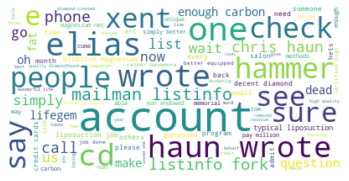

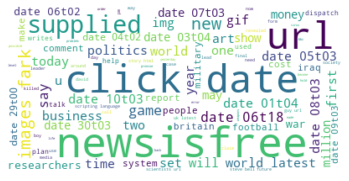

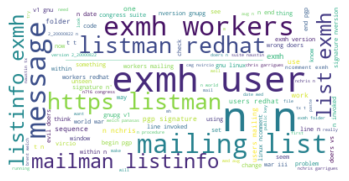

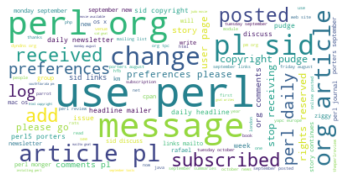

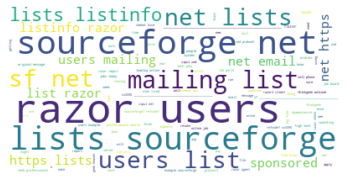

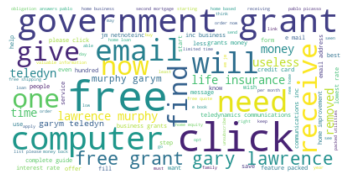

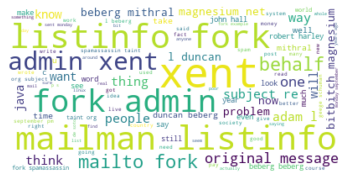

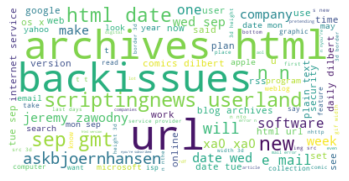

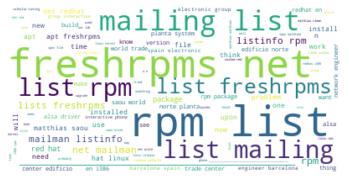

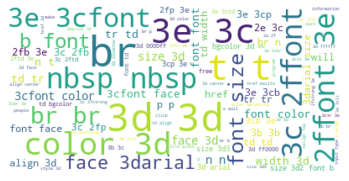

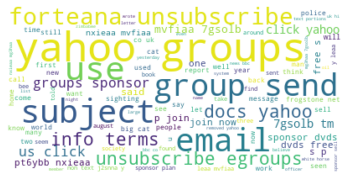

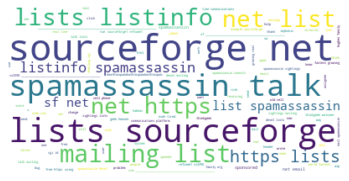

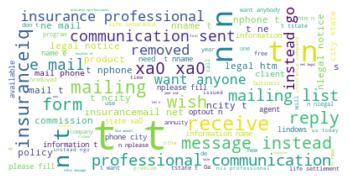

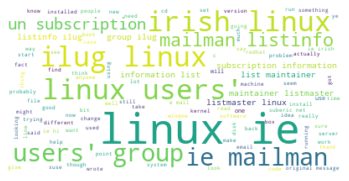

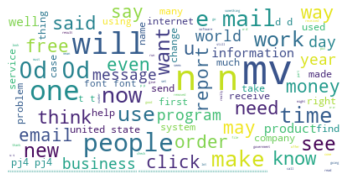

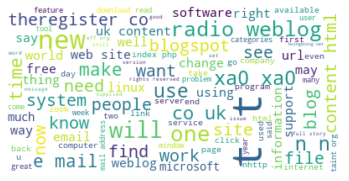

In [34]:
from wordcloud import WordCloud


#vectorizer = TfidfVectorizer(stop_words={'english'})
#my_stop_words = text.ENGLISH_STOP_WORDS.union(["spamassassin", "email", "message", "\n", "nbsp", "font","exhm", "subject", "list", "url", "net"])

vectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words=my_stop_words)



X = vectorizer.fit_transform(email_df.data_new)
clusters = list(kmeans.labels_)

kmeans_result={'cluster':clusters,'reviews':email_df.data_new}
kmeans_result=pd.DataFrame(kmeans_result)
for k in range(0,k_val):
   s=kmeans_result[kmeans_result.cluster==k]
   text=s['reviews'].str.cat(sep=' ')
   text=text.lower()
   text=' '.join([word for word in text.split()])
   wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
   plt.figure()
   plt.imshow(wordcloud, interpolation="bilinear")
   plt.axis("off")
   plt.show()

#### Logistic Regression

Logistic regression is a statistical model that in its basic form uses a logistic function to model a binary dependent variable

In [35]:
def displayModel_metrics(best_model, grid_model, features, target, cv):
    metrics = cross_validate(best_model, features, y=target, cv=cv, 
                             scoring=['accuracy','precision','recall'], return_train_score=True) 
    
    y_predict = cross_val_predict(best_model, features, target, cv=cv)

    print('\nBest Accuracy with Grid Search            : {:.3f}'.format(grid_model.best_score_))
    print('\nTraining data Metrics')
    print('\n     The average accuraccy : {:.3f}'.format(metrics['train_accuracy'].mean()))
    print('     The average precision : {:.3f}'.format(metrics['train_precision'].mean()))
    print('     The average recall    : {:.3f}'.format(metrics['train_recall'].mean()))

    print('\nTest data Metrics')
    print('\n     The average accuracy  : {:.3f}'.format(metrics['test_accuracy'].mean()))
    print('     The average precision : {:.3f}'.format(metrics['test_precision'].mean()))
    print('     The average  recall   : {:.3f}'.format(metrics['test_recall'].mean()))
    
    matrix = classification_report(target, y_predict, labels=[1,0])
    print('\nClassification report\n')
    print(matrix)

    
    
# Reference https://github.com/jakemdrew/DataMiningNotebooks/blob/master/06.%20Classification.ipynb
# ROC curve plot
def roc_curve_plot(model_fit, features, target):

    sns.set_palette("dark")

    yhat_score = model_fit.predict_proba(features)

    # Compute ROC curve for a subset of interesting classes
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in np.unique(target):
        fpr[i], tpr[i], _ = mt.roc_curve(target, yhat_score[:, i], pos_label=i)
        roc_auc[i] = mt.auc(fpr[i], tpr[i])

    for i in np.unique(target):
        plt.plot(fpr[i], tpr[i], label= ('class %d (area = %0.2f)' % (i, roc_auc[i])))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    plt.legend(loc="lower right")  
    plt.title('Receiver operating characteristic')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

In [36]:
LR = LogisticRegression()

In [37]:
LR.fit(new_vectors,email_df['target'])

LogisticRegression()

In [38]:
preds = LR.predict(new_vectors)

In [39]:
accuracy_score(email_df['target'],preds)

0.9869560568801454

#### Logistic Regression with GridsearchCV

GridSearch Parameters:

penalty: Used to specify the norm used in the penalization.

C: Inverse of regularization strength

max_iter: Maximum number of iterations taken for the solvers to converge.

class_weight: The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data .

solver:Algorithm to use in the optimization problem

In [40]:
#Create Cross Validation Procedure
cv = StratifiedKFold(n_splits=10, random_state=1234, shuffle=True)

In [41]:
LR = LogisticRegression()

# define parameters
penalty_LR = ['l1', 'l2', 'elasticnet', 'none'] 
#penalty_LR = [ 'l1', 'l2'] 
C_LR = [0.001, 0.01, 0.1, 1, 10, 100, 1000]  
#C_LR = [0.001,10, 100]  
max_iter_LR = [500]
#max_iter_LR = [500]
class_weight_LR = ['balanced']
#solver_LR = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
solver_LR = ['lbfgs', 'liblinear']

# define grid search
param_grid_LR = dict(penalty=penalty_LR, C=C_LR, max_iter=max_iter_LR, class_weight=class_weight_LR, solver=solver_LR)

grid_search_LR = GridSearchCV(estimator=LR, param_grid=param_grid_LR, n_jobs=-1, cv=cv, 
                              scoring='accuracy',error_score=0)

In [42]:
%%time
grid_result_LR = grid_search_LR.fit(new_vectors,email_df['target'])
# summarize results
print("Best: %f using %s" % (grid_result_LR.best_score_, grid_result_LR.best_params_))
means = grid_result_LR.cv_results_['mean_test_score']
stds = grid_result_LR.cv_results_['std_test_score']
params = grid_result_LR.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linea

/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linea

Best: 0.994654 using {'C': 100, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'l2', 'solver': 'lbfgs'}
0.000000 (0.000000) with: {'C': 0.001, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'l1', 'solver': 'lbfgs'}
0.743505 (0.000318) with: {'C': 0.001, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'l1', 'solver': 'liblinear'}
0.953064 (0.004943) with: {'C': 0.001, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'l2', 'solver': 'lbfgs'}
0.955524 (0.004939) with: {'C': 0.001, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'l2', 'solver': 'liblinear'}
0.000000 (0.000000) with: {'C': 0.001, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'elasticnet', 'solver': 'lbfgs'}
0.000000 (0.000000) with: {'C': 0.001, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'elasticnet', 'solver': 'liblinear'}
0.994334 (0.001514) with: {'C': 0.001, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'none', 'solver': 'lbfgs'}
0.000000 (0.00000

In [43]:
# The GridSearch algorithm determined the following optimal parameters
best_Estimator_LR =grid_result_LR.best_estimator_
best_Estimator_LR

LogisticRegression(C=100, class_weight='balanced', max_iter=500)

In [44]:
# 
results_LR = pd.DataFrame(grid_result_LR.cv_results_['params'])
results_LR['test_score'] = grid_result_LR.cv_results_['mean_test_score']
results_LR 

,C,class_weight,max_iter,penalty,solver,test_score
0,0.001,balanced,500,l1,lbfgs,0.000000
1,0.001,balanced,500,l1,liblinear,0.743505
2,0.001,balanced,500,l2,lbfgs,0.953064
3,0.001,balanced,500,l2,liblinear,0.955524
4,0.001,balanced,500,elasticnet,lbfgs,0.000000
5,0.001,balanced,500,elasticnet,liblinear,0.000000
6,0.001,balanced,500,none,lbfgs,0.994334
7,0.001,balanced,500,none,liblinear,0.000000
8,0.010,balanced,500,l1,lbfgs,0.000000
9,0.010,balanced,500,l1,liblinear,0.743505


In [45]:
# Display model metrics
displayModel_metrics(best_Estimator_LR, grid_result_LR, new_vectors,email_df['target'], cv)


Best Accuracy with Grid Search            : 0.995

Training data Metrics

     The average accuraccy : 1.000
     The average precision : 1.000
     The average recall    : 1.000

Test data Metrics

     The average accuracy  : 0.995
     The average precision : 0.990
     The average  recall   : 0.990

Classification report

              precision    recall  f1-score   support

           1       0.99      0.99      0.99      2399
           0       1.00      1.00      1.00      6954

    accuracy                           0.99      9353
   macro avg       0.99      0.99      0.99      9353
weighted avg       0.99      0.99      0.99      9353



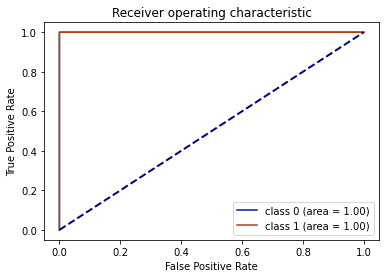

In [46]:
# Plot ROC curve
roc_curve_plot(grid_result_LR, new_vectors, email_df['target'])

#### Naive Bayes

It is a classification technique based on Bayes’ Theorem with an assumption of independence among predictors. In simple terms, a Naive Bayes classifier assumes that the presence of a particular feature in a class is unrelated to the presence of any other feature.

In [47]:
# Naive Bayes (NB) classifier 
clf = MultinomialNB().fit(new_vectors,email_df['target'])

In [48]:
# define parameters
C_nb = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]  
nb_prior=[True, False]

nb_clf = MultinomialNB()
# define grid search
param_grid_nb = dict(alpha=C_nb, fit_prior=nb_prior)

grid_search_nb = GridSearchCV(estimator=nb_clf, param_grid=param_grid_nb, n_jobs=-1, cv=cv, 
                              scoring='accuracy',error_score=0)

In [49]:
%%time
grid_result_nb = grid_search_nb.fit(new_vectors,email_df['target'])
# summarize results
print("Best: %f using %s" % (grid_result_nb.best_score_, grid_result_nb.best_params_))
means = grid_result_nb.cv_results_['mean_test_score']
stds = grid_result_nb.cv_results_['std_test_score']
params = grid_result_nb.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.994761 using {'alpha': 0.0001, 'fit_prior': True}
0.994761 (0.001470) with: {'alpha': 0.0001, 'fit_prior': True}
0.994654 (0.002139) with: {'alpha': 0.0001, 'fit_prior': False}
0.992408 (0.001689) with: {'alpha': 0.001, 'fit_prior': True}
0.990056 (0.002535) with: {'alpha': 0.001, 'fit_prior': False}
0.988452 (0.002903) with: {'alpha': 0.01, 'fit_prior': True}
0.984603 (0.004442) with: {'alpha': 0.01, 'fit_prior': False}
0.990592 (0.003470) with: {'alpha': 0.1, 'fit_prior': True}
0.993478 (0.002215) with: {'alpha': 0.1, 'fit_prior': False}
0.935422 (0.004705) with: {'alpha': 1, 'fit_prior': True}
0.971561 (0.005618) with: {'alpha': 1, 'fit_prior': False}
0.776328 (0.005109) with: {'alpha': 10, 'fit_prior': True}
0.909226 (0.005244) with: {'alpha': 10, 'fit_prior': False}
0.743505 (0.000318) with: {'alpha': 100, 'fit_prior': True}
0.867315 (0.008314) with: {'alpha': 100, 'fit_prior': False}
0.743505 (0.000318) with: {'alpha': 1000, 'fit_prior': True}
0.854805 (0.008522) with: {'

In [50]:
# The GridSearch algorithm determined the following optimal parameters
best_Estimator_nb =grid_result_nb.best_estimator_
best_Estimator_nb

MultinomialNB(alpha=0.0001)

In [51]:
# Display model metrics
displayModel_metrics(best_Estimator_nb, grid_result_nb, new_vectors,email_df['target'], cv)


Best Accuracy with Grid Search            : 0.995

Training data Metrics

     The average accuraccy : 0.999
     The average precision : 1.000
     The average recall    : 0.996

Test data Metrics

     The average accuracy  : 0.995
     The average precision : 0.989
     The average  recall   : 0.991

Classification report

              precision    recall  f1-score   support

           1       0.99      0.99      0.99      2399
           0       1.00      1.00      1.00      6954

    accuracy                           0.99      9353
   macro avg       0.99      0.99      0.99      9353
weighted avg       0.99      0.99      0.99      9353



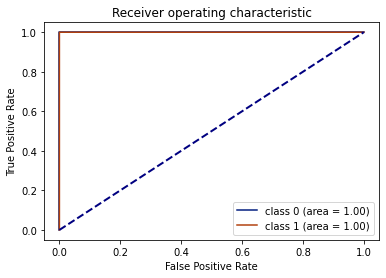

In [52]:
# Plot ROC curve
roc_curve_plot(grid_result_nb, new_vectors, email_df['target'])

### Clustering

#### KMeans Clustering

K-means clustering is a type of unsupervised learning, which is used when you have unlabeled data (i.e., data without defined categories or groups). The goal of this algorithm is to find groups in the data, with the number of groups represented by the variable K. The algorithm works iteratively to assign each data point to one of K groups based on the features that are provided. Data points are clustered based on feature similarity

KMeans Clustering with default parameters

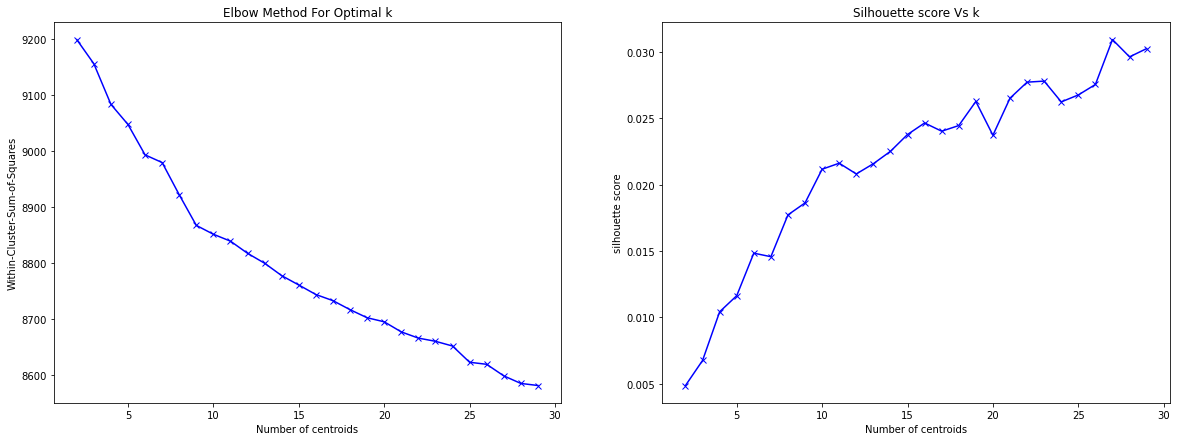

In [53]:
wcss = []
score = []
K = range(2,30)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(new_vectors)
    labels = km.predict(new_vectors) 
    wcss.append(km.inertia_)
    sc = silhouette_score(new_vectors, labels)
    score.append(sc)

plt.rcParams['figure.figsize'] = (20, 7)
plt.subplot(1,2,1)
plt.plot(K, wcss, 'bx-')
plt.xlabel('Number of centroids')
plt.ylabel('Within-Cluster-Sum-of-Squares')
plt.title('Elbow Method For Optimal k')

plt.subplot(1,2,2)
plt.plot(K, score, 'bx-')
plt.xlabel('Number of centroids')
plt.ylabel('silhouette score')
plt.title('Silhouette score Vs k')
plt.show()

We set up our K-means clustering algorithm with an init of k-means++ with a number of clusters between 2 and 15 to test against our dataframe.

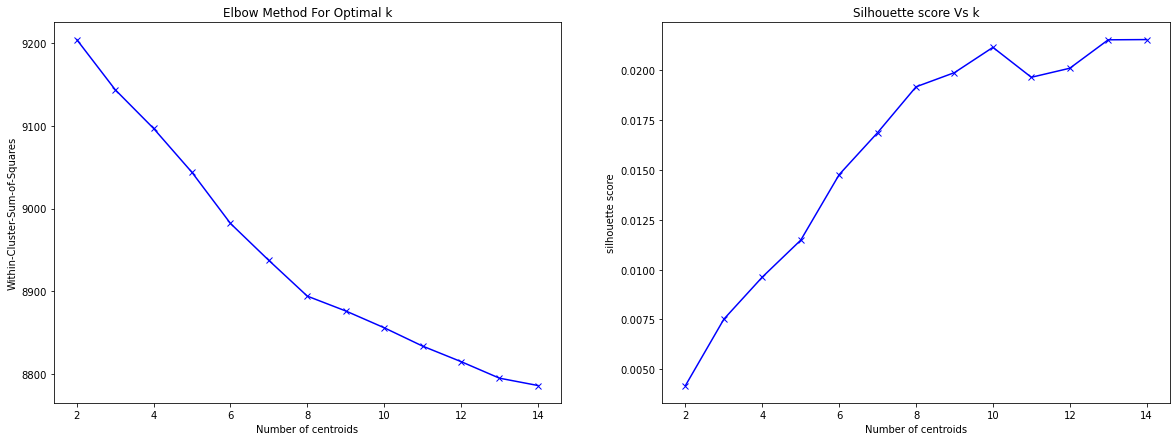

CPU times: user 13min 25s, sys: 5min 30s, total: 18min 56s
Wall time: 4min 2s


In [54]:
%%time
wcss = []
score = []
K = range(2,15)
for k in K:
    km = KMeans(n_clusters=k, init = 'k-means++')
    km = km.fit(new_vectors)
    labels = km.predict(new_vectors) 
    wcss.append(km.inertia_)
    sc = silhouette_score(new_vectors, labels)
    score.append(sc)

plt.rcParams['figure.figsize'] = (20, 7)
plt.subplot(1,2,1)
plt.plot(K, wcss, 'bx-')
plt.xlabel('Number of centroids')
plt.ylabel('Within-Cluster-Sum-of-Squares')
plt.title('Elbow Method For Optimal k')

plt.subplot(1,2,2)
plt.plot(K, score, 'bx-')
plt.xlabel('Number of centroids')
plt.ylabel('silhouette score')
plt.title('Silhouette score Vs k')
plt.show()

#### HDBSCAN (Hierarchical extension of DBSCAN) Clustering

HDBSCAN is a clustering algorithm which extends DBSCAN a density-based clustering method by converting it into a hierarchical clustering algorithm, and then using a technique to extract a flat clustering based in the stability of clusters.

There are 2 primary parameters available for tuning in HDBSCAN.

- Minimum Cluster Size: This is the smallest number of observations you wish to consider a cluster
- Minimum Samples: This drives how conservative the clustering is: the higher the value, the more conservative the algorithm will be

http://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html.

In [ ]:
%%time
clusterer = hdbscan.HDBSCAN(min_cluster_size=1000, min_samples=5).fit(new_vectors)
newfeature = clusterer.labels_ 
X_DBS_clusters = np.column_stack((new_vectors.toarray(), pd.get_dummies(newfeature)))

In [ ]:
print("Number of Clusters Identified with HDBSCAN :", (max(newfeature)))

In [ ]:
pred =  clusterer.labels_
# Get silhouette score
dbs_sil = silhouette_score(new_vectors.toarray(), pred, random_state=1234)
print("Average HDBSCAN Silhouette Score:", dbs_sil)

#### Visualize Clusters

We will use a technique called t-SNE (t-distributed Stochastic Neighbor Embedding) to generate a 2 dimensional representation of our dataset, in order to have a more intuitive understanding of how the clustering looks.

First let's look at an un-clustered version of this 2D projection.

In [ ]:
%%time
from sklearn.manifold import TSNE
import sklearn.cluster as cluster
newdims = (12, 8)
plt.subplots(1, 1, figsize=newdims)
plt.subplot(1, 1, 1)
plot_kwds = {'alpha' : 0.25, 's' : 40, 'linewidths':0}
projection = TSNE().fit_transform(new_vectors)
plt.scatter(*projection.T, **plot_kwds)
plt.show()

Now look at clustered version of this 2D projection with various clustering techniques

In [ ]:
%%time
import seaborn as sns

# This function will run a given clustering algorithm and plot the clusters on the same 2D  TSNE projection as above
def plot_clusters(data, algorithm, args, kwds):
    labels = algorithm(*args, **kwds).fit_predict(data)
    palette = sns.color_palette('muted', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (.5, .5, .5) for x in labels]
    plt.scatter(*projection.T, s=50, linewidth=0, c=colors, alpha=0.25)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=14)

In [ ]:
%%time
# plot the clusters
newdims = (12, 8)
plt.subplots(1, 1, figsize=newdims)
plt.subplot(1, 1, 1)
plot_clusters(new_vectors, cluster.KMeans, (), {'n_clusters':2})

#plt.subplot(2,2,2)
#plot_clusters(new_vectors.toarray(), hdbscan.HDBSCAN, (), {'min_cluster_size':1000, 'min_samples':5})
